## Gaussian Process Exploration
<b>Objective:</b> Figure out how to model PLAsTiCC lightcurves with Gaussian Process Regression. <br>
<b>Note:</b> I originally wanted to learn how to do this on my own using `george`, but later decided that that was not a good use of my time and effots. The notebook `Gaussian Process Avocado.ipynb` contains an example of modelling PLAsTiCC lightcurves with `avocado`.

In [1]:
# Imports

# Standard
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Auxilliary
import george
from george import kernels

from scipy.optimize import minimize

In [2]:
print(george.__file__)

/astro/users/lfulmer/.conda/envs/earthseed/lib/python3.8/site-packages/george/__init__.py


In [3]:
# Settings
rcParams['figure.figsize'] = [6.5, 6.5]
rcParams['font.size'] = 10

In [4]:
# PLAsTiCC Data

# object_id, mjd, passband, flux, flux_err, detected
train = pd.read_csv("../plasticc/training_set.csv")

# object_id, ra, decl, gal_l, gal_b, ddf, hostgal_specz, hostgal_photoz, hostgal_photoz_err, distmod, mwebv, target
train_meta = pd.read_csv("../plasticc/training_set_metadata.csv")

In [9]:
# Let's look at the data by individual class
classes = train_meta['target'].unique()
classes.sort()

# Create a dictionary of classes and pull all of the training data (every single observation) for each class
data_by_class = {cl : train[train['object_id'].isin(train_meta['object_id'][train_meta['target'] == cl])] \
                for cl in classes}

# ... and look at the objects by class
# Determine the unique objects within an individual class
objects_by_class = {cl : data_by_class[cl]['object_id'].unique() \
                  for cl in classes}

# ... and lightcurves by class
# Sort all the data by object
lightcurves_by_class = { cl : [ data_by_class[cl][data_by_class[cl]['object_id'] == o] for o in objects_by_class[cl] ] \
                       for cl in classes }

In [10]:
# Separate the lightcurves for each passband

def lightcurves_by_passband(data):
    return [ data[data['passband'] == i] for i in data['passband'].unique() ]

def lightcurves_collect_passbands(data, passbands):
    if type(passbands) == int:
        return data[data['passband'] == passbands ]
    
    observations = pd.DataFrame(columns = data.columns)
   
    for i in range(len(data)):
        if data.iloc[i]['passband'] in passbands:
            observation = pd.DataFrame([data.iloc[i]], columns=data.columns)
            observations = observations.append(observation, ignore_index=True)
    return observations

In [11]:
# Model the lightcurves with gaussian processes

def model_lightcurve(scale_length, x, y, yerr, ndim):
    
    def neg_ln_likelihood(p):
        gp.set_parameter_vector(p)
        return -gp.log_likelihood(y)

    def grad_neg_ln_likelihood(p):
        gp.set_parameter_vector(p)
        return -gp.grad_log_likelihood(y)
    
    kernel = np.var(y) * kernels.ExpSquaredKernel(scale_length, ndim = ndim)
    
    gp = george.GP(kernel)
    gp.compute(x, yerr)
    
    x_predict = np.linspace(min(x), max(x), 500)
    predict, predict_var = gp.predict(y, x_predict, return_var = True)
    result = minimize(neg_ln_likelihood, gp.get_parameter_vector(), jac = grad_neg_ln_likelihood)
    gp.set_parameter_vector(result.x)

    return x_predict, predict, predict_var

In [19]:
# Plot the light curve of a selected object in each passband
def plot_lightcurves(cl, example_object, passbands):
    data = lightcurves_by_class[cl][example_object]
    
    data_by_passband = lightcurves_by_passband(data)
    data_collect_passbands = lightcurves_collect_passbands(data, passbands)
    
    passbands = { 0 : 'u', 1 : 'g', 2 : 'r', 3 : 'i', 4 : 'z', 5 : 'y' }
    colors = { 0 : 'k', 1 : 'maroon', 2 : 'firebrick', 3 : 'crimson', 4 : 'tomato', 5 : 'lightsalmon' }
    wavelengths_dictionary = { 0 : 3671.0, 1 : 4827.0, 2 : 6223.0, 3 : 7546.0, 4 : 8691.0, 5 : 9710.0 }
    
    times = data_collect_passbands['mjd']
    # wavelengths = [wavelengths_dictionary.get(i) for i in data_collect_passbands['passband'].values]
    

    a,b = 2,3
    plt.figure(figsize=(5.5*b, 5.5*a))
    
    for i, data_passband in enumerate(data_by_passband):
            
        # Variable definition
        x = data_passband['mjd']
        y = data_passband['flux']
        y_err = data_passband['flux_err']
            
        scale_length = int(max(x) - min(x))
        ndim = 1

        x_predict, predict, predict_var = model_lightcurve(scale_length, x, y, y_err, ndim)
            
        # Plot
        plt.subplot(a, b, i+1)
        plt.errorbar(x, y, yerr = y_err, fmt = 'o',\
                    color = colors[i], markersize = 5, label=f"{passbands[i]}")
            
        plt.fill_between(x_predict, predict - np.sqrt(predict_var), \
                        predict + np.sqrt(predict_var), color = 'k', alpha = 0.2)
            
        plt.plot(x_predict, predict, 'k', lw = 1.5, alpha = 0.5)

        plt.legend(loc='upper right', ncol=1)
        plt.xlabel('Time [MJD]')
        plt.ylabel('Flux')
        plt.title(f'Class {cl} : Object {objects_by_class[cl][example_object]}', size=14)

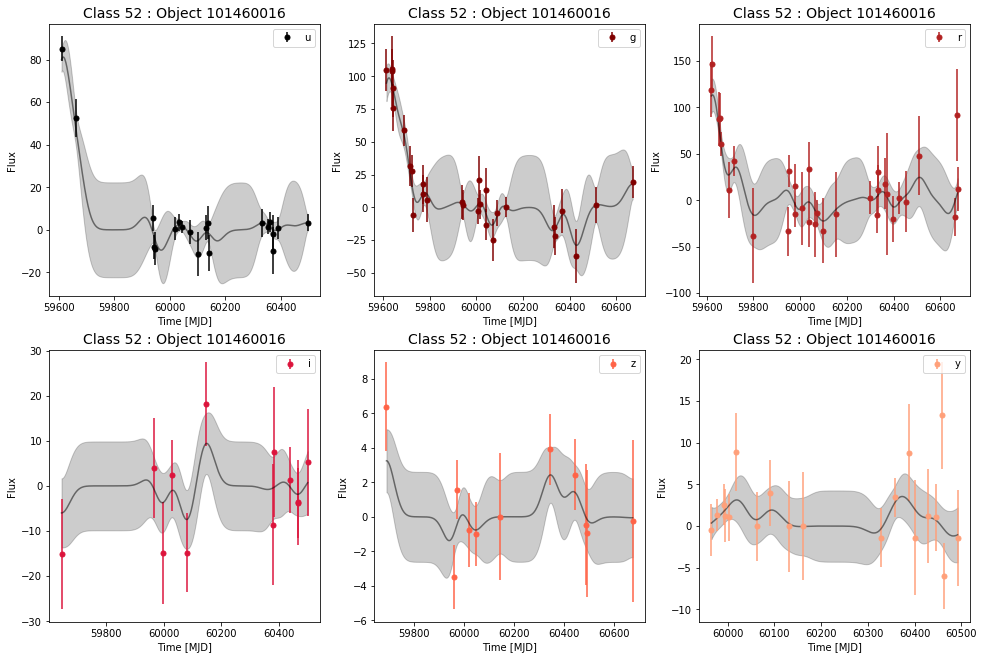

In [22]:
# Plot an example object, by bandpass

cl = np.random.choice(classes)
n_objects = len(lightcurves_by_class[cl])

example_object = np.random.randint(n_objects)
passbands = (0,1,2,3,4,5)

# plot_lightcurves(cl, example_object, passbands, expand = False, model = False)
plot_lightcurves(cl, example_object, passbands)

## Resting place